In [1]:
import sns
import tensorflow as tf
import cv2
import numpy as np
import os
import json
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2023-10-19 18:47:32.422739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 18:47:33.106937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.pyplot as plt

# create empty lists to store loss and epoch values
train_loss = []
val_loss = []
epochs = []

# define a function to update the plot
def update_plot(epoch, train_loss_value, val_loss_value):
    epochs.append(epoch)
    train_loss.append(train_loss_value)
    val_loss.append(val_loss_value)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# define a callback to update the plot after every epoch
class PlotLossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        update_plot(epoch, logs['loss'], logs['val_loss'])
        

In [3]:
X_RES = 227
Y_RES = 227

In [4]:
def build_model (train_model=False):
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    model = keras.Sequential()
    
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu', input_shape=(Y_RES, X_RES, 3), padding='valid'))
    model.add(MaxPooling2D(2, 2))   
    if train_model:
        model.add(Dropout(0.4))
    

    model.add(Conv2D(320, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if train_model:
        model.add(Dropout(0.2))
    

    model.add(Conv2D(480, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if train_model:
        model.add(Dropout(0.2))
    
    
    model.add(Flatten())
    model.add(Dense(384, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model


In [5]:

model = build_model(train_model=True)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 320)     368960    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 320)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 55, 55, 320)       0

2023-10-19 18:48:08.506042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 18:48:08.585586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 18:48:08.586320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
train_dir = '/home/mayank/programs/mids/DriverDrowsiness/data/train'


batch_size = 16

train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
            rotation_range=5,  # Rotate images by up to 20 degrees
            width_shift_range=0.2,  # Shift the width of the image by up to 20%
            height_shift_range=0.2,  # Shift the height of the image by up to 20%
            shear_range=0.2,  # Apply shear transformation
            zoom_range=0.2,  # Zoom in by up to 20%
            horizontal_flip=False,  # Flip images horizontally
            fill_mode='nearest',  # Fill in missing pixels with the nearest value
            validation_split=0.3
        )



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True

)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True

)

Found 20480 images belonging to 2 classes.
Found 8776 images belonging to 2 classes.


Epoch 1/10


2023-10-19 18:52:40.505664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-19 18:52:41.208209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-19 18:52:42.470123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-19 18:52:43.548924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-19 18:52:43.565496: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6ec8011d80 in

1280/1280 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.6556

2023-10-19 18:55:23.591191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


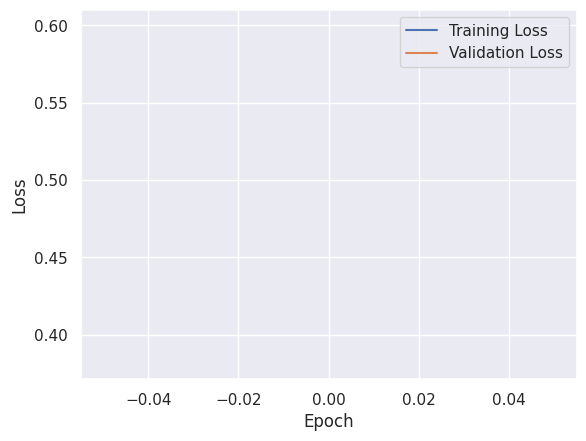

1280/1280 [==============================] - 225s 170ms/step - loss: 0.5993 - accuracy: 0.6556 - val_loss: 0.3821 - val_accuracy: 0.8135
Epoch 2/10
1280/1280 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.8894

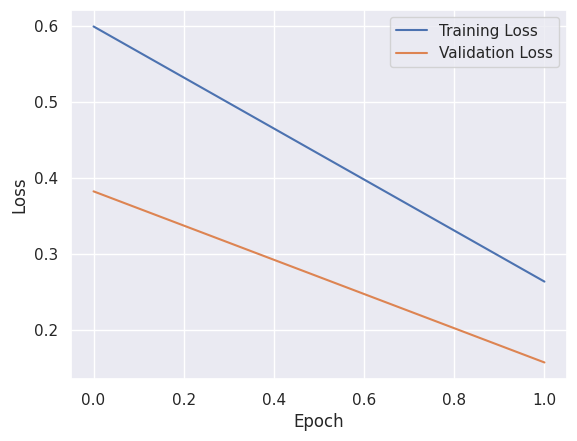

1280/1280 [==============================] - 212s 166ms/step - loss: 0.2632 - accuracy: 0.8894 - val_loss: 0.1568 - val_accuracy: 0.9450
Epoch 3/10
1280/1280 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9398

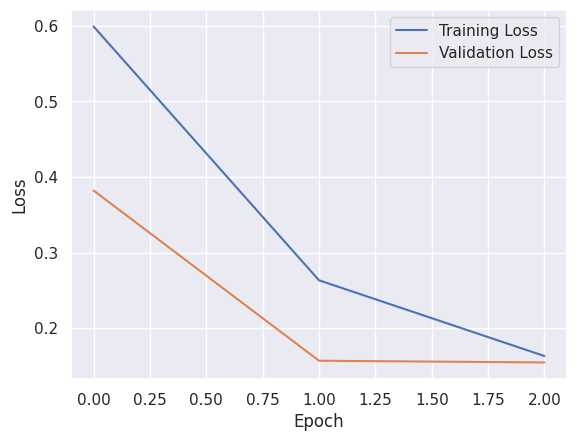

1280/1280 [==============================] - 209s 163ms/step - loss: 0.1630 - accuracy: 0.9398 - val_loss: 0.1545 - val_accuracy: 0.9421
Epoch 4/10
1280/1280 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9606

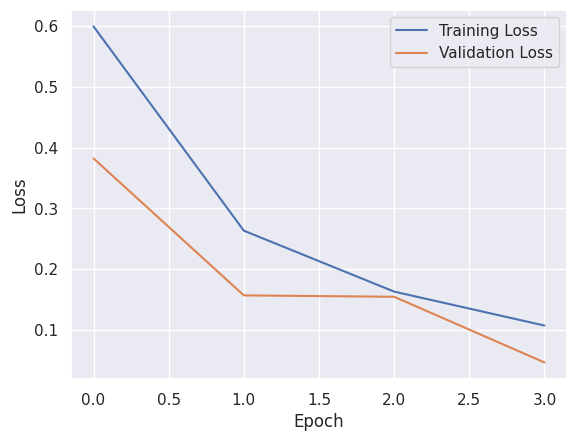

1280/1280 [==============================] - 211s 165ms/step - loss: 0.1071 - accuracy: 0.9606 - val_loss: 0.0464 - val_accuracy: 0.9854
Epoch 5/10
1280/1280 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9739

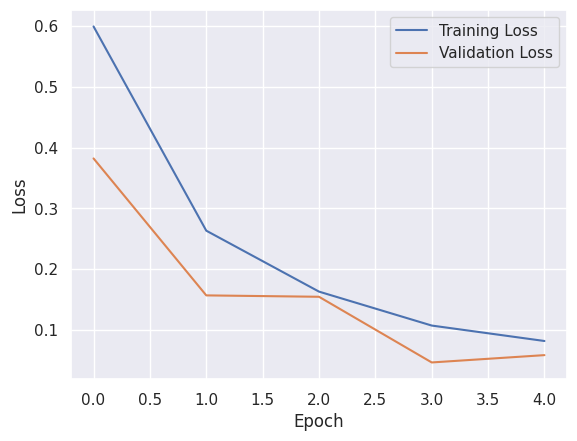

1280/1280 [==============================] - 212s 166ms/step - loss: 0.0817 - accuracy: 0.9739 - val_loss: 0.0585 - val_accuracy: 0.9831
Epoch 6/10
1280/1280 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9808

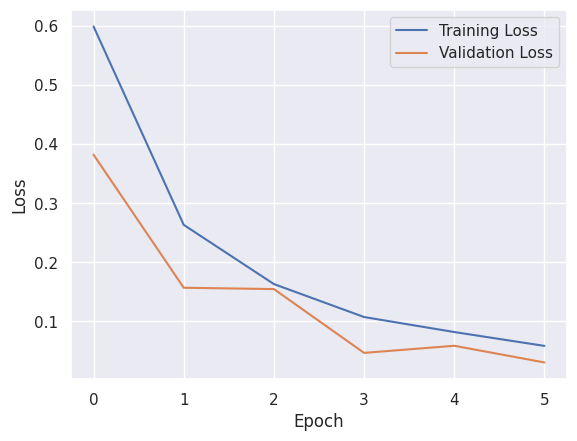

1280/1280 [==============================] - 209s 163ms/step - loss: 0.0583 - accuracy: 0.9808 - val_loss: 0.0302 - val_accuracy: 0.9901
Epoch 7/10
1280/1280 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9848

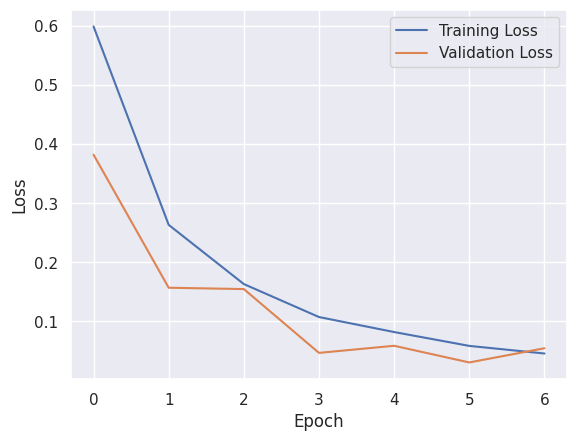

1280/1280 [==============================] - 209s 163ms/step - loss: 0.0454 - accuracy: 0.9848 - val_loss: 0.0543 - val_accuracy: 0.9774
Epoch 8/10
1280/1280 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9872

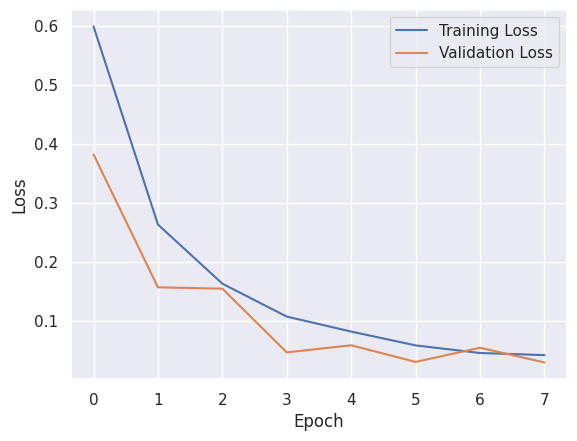

1280/1280 [==============================] - 210s 164ms/step - loss: 0.0418 - accuracy: 0.9872 - val_loss: 0.0294 - val_accuracy: 0.9924
Epoch 9/10
1280/1280 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9873

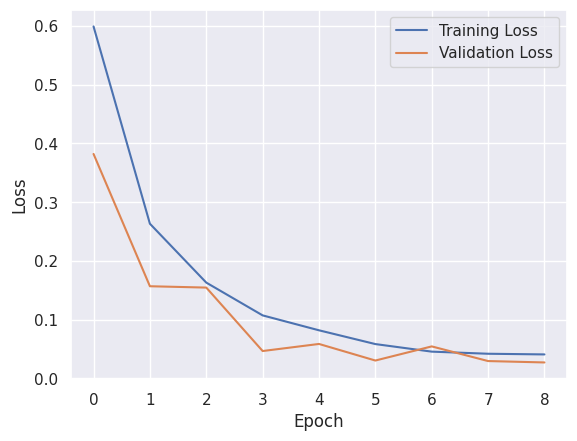

1280/1280 [==============================] - 214s 167ms/step - loss: 0.0407 - accuracy: 0.9873 - val_loss: 0.0270 - val_accuracy: 0.9928
Epoch 10/10
1280/1280 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9852

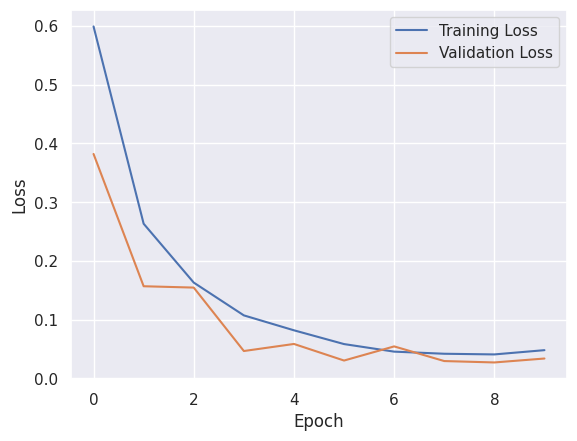

1280/1280 [==============================] - 211s 165ms/step - loss: 0.0479 - accuracy: 0.9852 - val_loss: 0.0337 - val_accuracy: 0.9885


In [8]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[PlotLossCallback()])

In [9]:
model.save('dd_model.h5')   



2023-10-19 19:28:03.049678: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 498401280 exceeds 10% of free system memory.
2023-10-19 19:28:03.501497: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 498401280 exceeds 10% of free system memory.
2023-10-19 19:28:03.751597: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 498401280 exceeds 10% of free system memory.


In [10]:
test_dir = '/home/mayank/programs/mids/DriverDrowsiness/data/test'

test_datagen = ImageDataGenerator(
            rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
        )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(X_RES, Y_RES),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Found 12537 images belonging to 2 classes.
  3/784 [..............................] - ETA: 29s - loss: 0.0014 - accuracy: 1.0000 

2023-10-19 19:29:01.602892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


784/784 [==============================] - 27s 34ms/step - loss: 0.0026 - accuracy: 0.9993
Test Loss: 0.0026, Test Accuracy: 0.9993


In [11]:
def predict(model, img):
    img= keras.utils.load_img(
        img, target_size=(X_RES, Y_RES))
    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)

    return predictions

In [ ]:
#model = keras.models.load_model('dd_model.h5')


In [23]:
import  pandas as pd
from IPython.display import display

dir_path = '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/'
i = 0
prediction_results = []
for file_name in os.listdir(dir_path):
    
    predictions = predict(model, dir_path+file_name)
    
    dp, fn = os.path.split(dir_path)
    prediction_results.append([os.path.basename(dp)+'/'+file_name, predictions[0][0], predictions[0][1]])
    i = i + 1
    if i == 100:
        break

df = pd.DataFrame(prediction_results, columns=['Filename', 'Drowsy', 'Non-Drowsy'])
display(df)

1/1 [==============================] - 0s 16ms/step


,Filename,Drowsy,Non-Drowsy
0,NonDrowsy/a0450.png,1.613725e-06,0.999998
1,NonDrowsy/zb0622.png,1.172499e-09,1.000000
2,NonDrowsy/d0310.png,7.387836e-05,0.999926
3,NonDrowsy/n0294.png,1.948194e-33,1.000000
4,NonDrowsy/e0553.png,9.214145e-03,0.990786
...,...,...,...
95,NonDrowsy/c0270.png,1.588861e-10,1.000000
96,NonDrowsy/za0876.png,2.670997e-05,0.999973
97,NonDrowsy/za0859.png,1.632757e-05,0.999984
98,NonDrowsy/r0125.png,1.083196e-19,1.000000
